In [457]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import learning_curve

In [459]:
data = pd.read_csv(r"C:\Users\karth\OneDrive\Desktop\csv files\Water Quality Testing.csv")

In [461]:
data.head()

,Sample ID,pH,Temperature (°C),Turbidity (NTU),Dissolved Oxygen (mg/L),Conductivity (µS/cm)
0,1,7.25,23.1,4.5,7.8,342
1,2,7.11,22.3,5.1,6.2,335
2,3,7.03,21.5,3.9,8.3,356
3,4,7.38,22.9,3.2,9.5,327
4,5,7.45,20.7,3.8,8.1,352


In [463]:
data['pH_normalized'] = (data['pH'] - 6.5) / (8.5 - 6.5) * 100

data['Temperature_normalized'] = (data['Temperature (°C)'] - 15) / (25 - 15) * 100

data['Turbidity_normalized'] = (5 - data['Turbidity (NTU)']) / 5 * 100

data['DO_normalized'] = (data['Dissolved Oxygen (mg/L)'] - 4) / (10 - 4) * 100

data['Conductivity_normalized'] = (500 - data['Conductivity (µS/cm)']) / 500 * 100

weights = {
    'pH_normalized': 0.25,
    'Temperature_normalized': 0.20,
    'Turbidity_normalized': 0.15,
    'DO_normalized': 0.25,
    'Conductivity_normalized': 0.15
}

data['WQI'] = (
    data['pH_normalized'] * weights['pH_normalized'] +
    data['Temperature_normalized'] * weights['Temperature_normalized'] +
    data['Turbidity_normalized'] * weights['Turbidity_normalized'] +
    data['DO_normalized'] * weights['DO_normalized'] +
    data['Conductivity_normalized'] * weights['Conductivity_normalized']
)

In [465]:
data.head()

,Sample ID,pH,Temperature (°C),Turbidity (NTU),Dissolved Oxygen (mg/L),Conductivity (µS/cm),pH_normalized,Temperature_normalized,Turbidity_normalized,DO_normalized,Conductivity_normalized,WQI
0,1,7.25,23.1,4.5,7.8,342,37.5,81.0,10.0,63.333333,31.6,47.648333
1,2,7.11,22.3,5.1,6.2,335,30.5,73.0,-2.0,36.666667,33.0,36.041667
2,3,7.03,21.5,3.9,8.3,356,26.5,65.0,22.0,71.666667,28.8,45.161667
3,4,7.38,22.9,3.2,9.5,327,44.0,79.0,36.0,91.666667,34.6,60.306667
4,5,7.45,20.7,3.8,8.1,352,47.5,57.0,24.0,68.333333,29.6,48.398333


In [467]:
data=data.drop(columns=["pH","Temperature (°C)","Turbidity (NTU)","Dissolved Oxygen (mg/L)","Conductivity (µS/cm)"])

In [469]:
data.head()

,Sample ID,pH_normalized,Temperature_normalized,Turbidity_normalized,DO_normalized,Conductivity_normalized,WQI
0,1,37.5,81.0,10.0,63.333333,31.6,47.648333
1,2,30.5,73.0,-2.0,36.666667,33.0,36.041667
2,3,26.5,65.0,22.0,71.666667,28.8,45.161667
3,4,44.0,79.0,36.0,91.666667,34.6,60.306667
4,5,47.5,57.0,24.0,68.333333,29.6,48.398333


In [471]:
data.describe()

,Sample ID,pH_normalized,Temperature_normalized,Turbidity_normalized,DO_normalized,Conductivity_normalized,WQI
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,33.057000,70.544000,16.612000,73.036667,31.127600,47.793157
std,144.481833,5.376529,9.031234,7.949834,13.706607,2.607734,5.381585
min,1.000000,16.500000,53.000000,-2.000000,33.333333,26.000000,33.243333
25%,125.750000,29.000000,62.000000,10.000000,63.333333,29.000000,43.447500
50%,250.500000,33.000000,72.000000,16.000000,73.333333,31.200000,47.801667
75%,375.250000,37.500000,79.000000,24.000000,85.000000,33.400000,52.210417
max,500.000000,49.000000,86.000000,38.000000,98.333333,36.800000,60.306667


In [473]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sample ID                500 non-null    int64  
 1   pH_normalized            500 non-null    float64
 2   Temperature_normalized   500 non-null    float64
 3   Turbidity_normalized     500 non-null    float64
 4   DO_normalized            500 non-null    float64
 5   Conductivity_normalized  500 non-null    float64
 6   WQI                      500 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 27.5 KB


In [475]:
# Define features and target
X = data[['pH_normalized', 'Temperature_normalized', 'Turbidity_normalized', 
        'DO_normalized', 'Conductivity_normalized']]
y = data['WQI']

In [477]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [481]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [483]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [484]:
y_pred = model.predict(X_test)

In [487]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [489]:
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.5113741482277736
R² Score: 0.9817954532886914


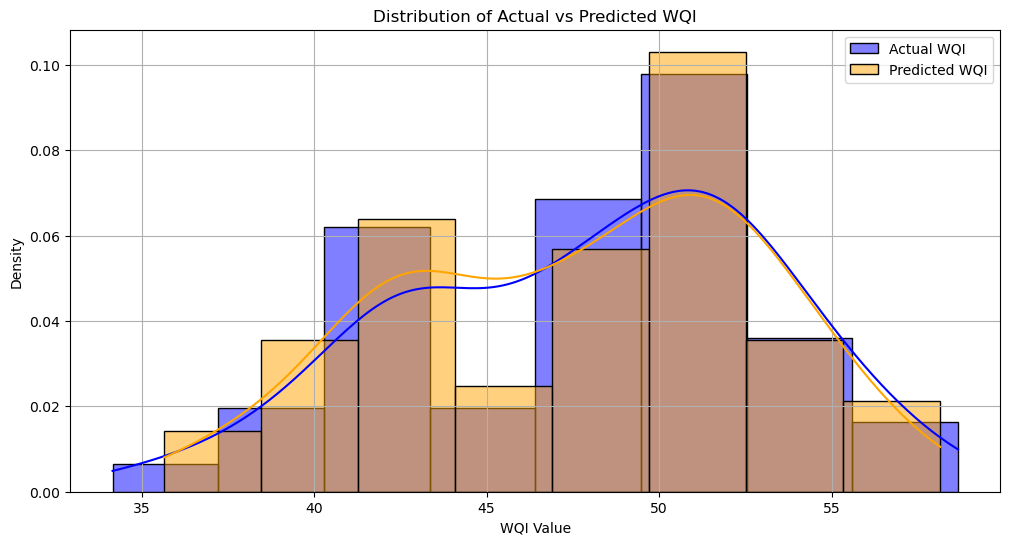

In [491]:
# Distribution of Actual vs Predicted WQI
plt.figure(figsize=(12, 6))
sns.histplot(y_test, color='blue', label='Actual WQI', kde=True, stat='density', alpha=0.5)
sns.histplot(y_pred, color='orange', label='Predicted WQI', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Actual vs Predicted WQI')
plt.xlabel('WQI Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

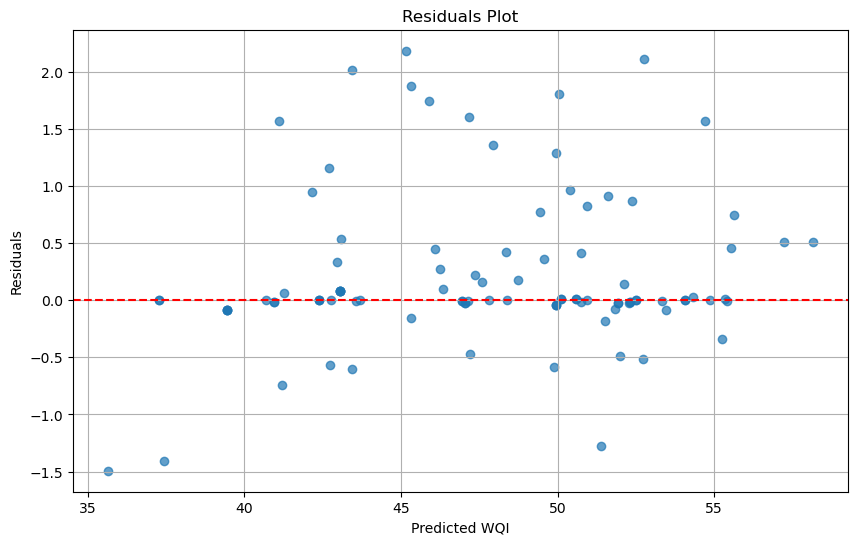

In [492]:
# Residuals Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted WQI')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


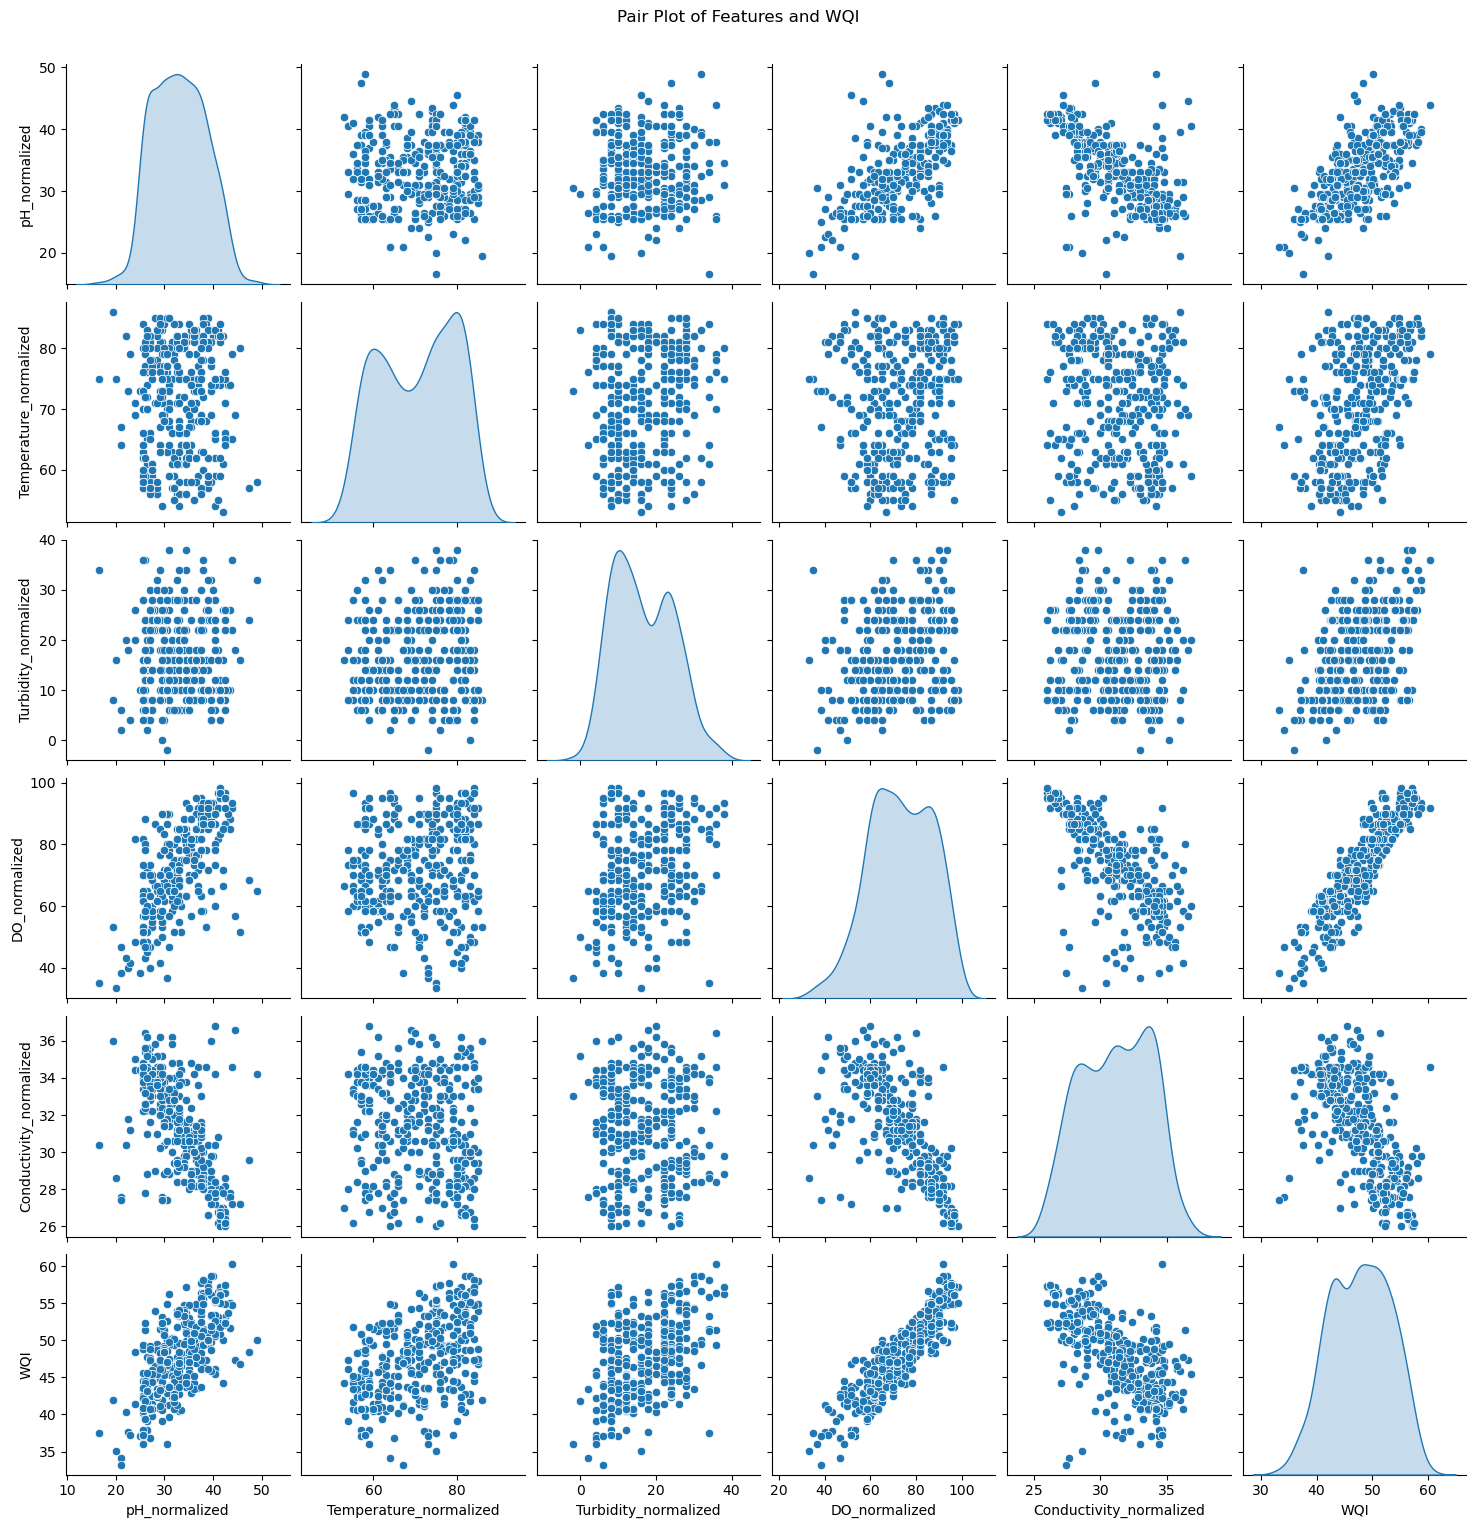

In [547]:
sns.pairplot(data, vars=['pH_normalized', 'Temperature_normalized', 'Turbidity_normalized', 
                        'DO_normalized', 'Conductivity_normalized', 'WQI'], diag_kind='kde')
plt.suptitle('Pair Plot of Features and WQI', y=1.02)
plt.show()


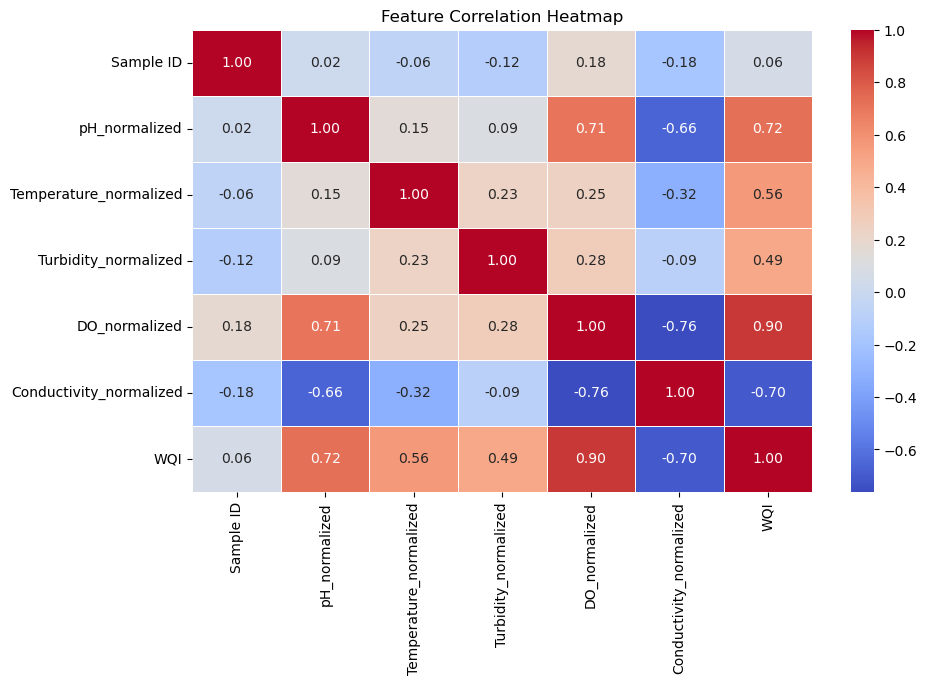

In [548]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


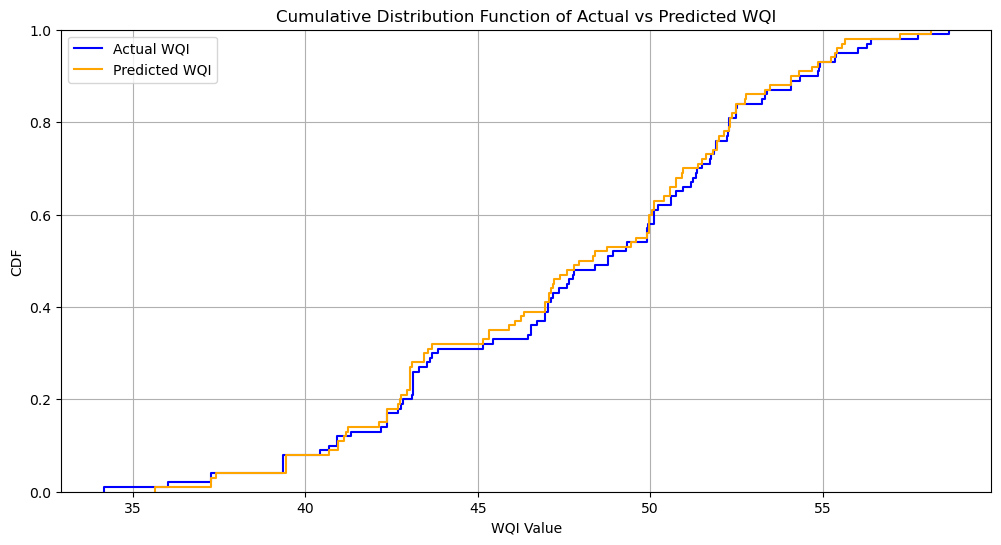

In [496]:
# CDF of Actual vs Predicted WQI
plt.figure(figsize=(12, 6))
sns.ecdfplot(y_test, label='Actual WQI', color='blue')
sns.ecdfplot(y_pred, label='Predicted WQI', color='orange')
plt.title('Cumulative Distribution Function of Actual vs Predicted WQI')
plt.xlabel('WQI Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


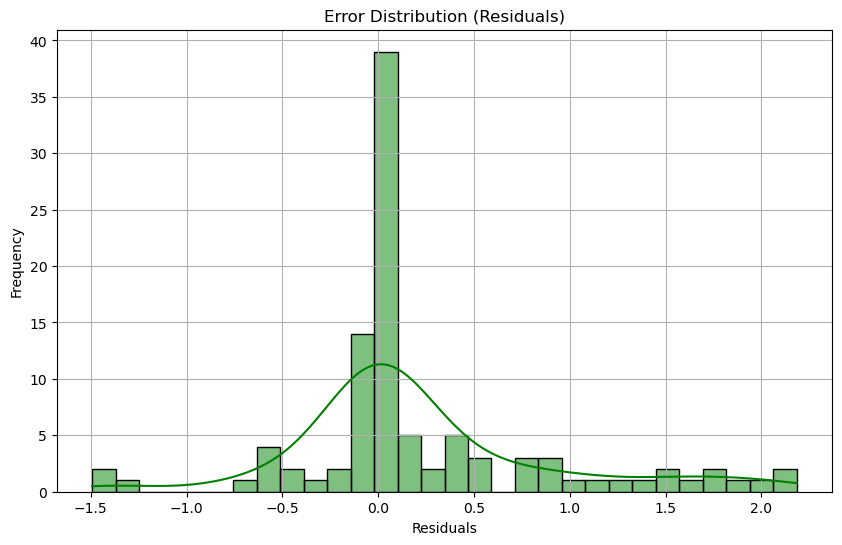

In [498]:
# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='green', bins=30)
plt.title('Error Distribution (Residuals)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


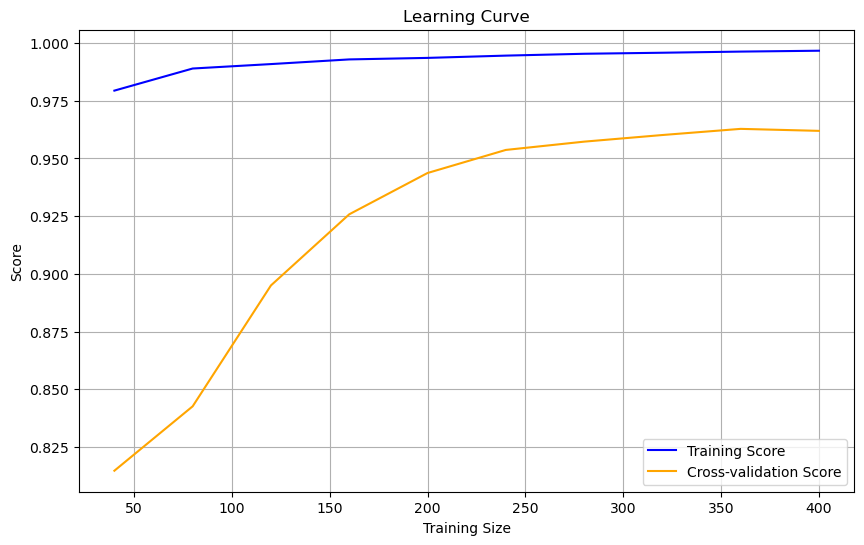

In [499]:
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=5, n_jobs=-1,
                                                          train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation Score', color='orange')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [533]:
features = ['pH_normalized', 'Temperature_normalized', 'Turbidity_normalized', 
            'DO_normalized', 'Conductivity_normalized']
target = 'WQI'


In [535]:
X = data[features]
y = data[target]

In [537]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [539]:
bagging_model = BaggingRegressor(n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)

In [541]:
# Bagging Regressor
bagging_model = BaggingRegressor(n_estimators=50, random_state=42)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)

    # Boosting Regressor
boosting_model = GradientBoostingRegressor(n_estimators=50, random_state=42)
boosting_model.fit(X_train, y_train)
boosting_predictions = boosting_model.predict(X_test)

    # Evaluate models
bagging_mse = mean_squared_error(y_test, bagging_predictions)
boosting_mse = mean_squared_error(y_test, boosting_predictions)
    
print(f"Bagging MSE: {bagging_mse:.2f}")
print(f"Boosting MSE: {boosting_mse:.2f}")

Bagging MSE: 0.53
Boosting MSE: 0.54


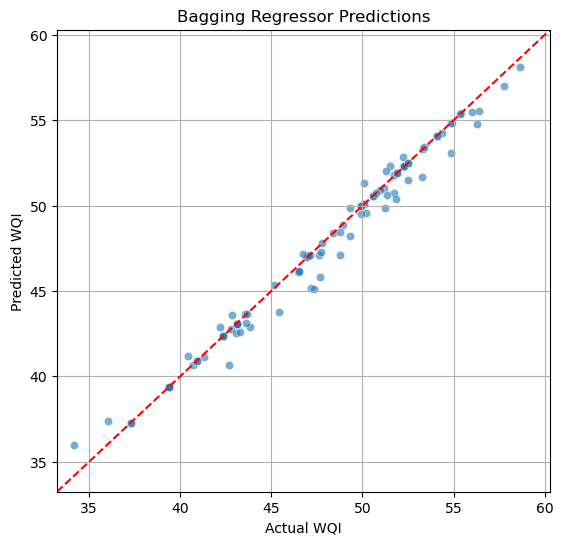

In [543]:
plt.figure(figsize=(14, 6))

# Plot Bagging Predictions
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=bagging_predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title('Bagging Regressor Predictions')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid(True)

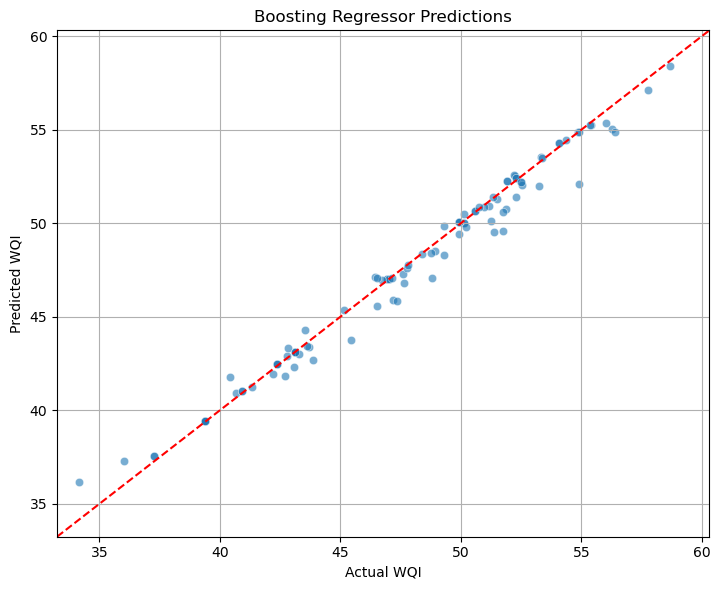

In [544]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=boosting_predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title('Boosting Regressor Predictions')
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid(True)

plt.tight_layout()
plt.show()